# Results analysis
Notebook to analyze the results of the various state-of-the-artn detectors.

## Libraries import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib as mpl
import seaborn
mpl.use("pgf")
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
mpl.rcParams.update(pgf_with_rc_fonts)
import matplotlib.pyplot as plt
fontsize = 18
plt.rc('text', usetex=True)
plt.rc('font', family='sans',size=fontsize)
plt.rc('legend',fontsize=fontsize)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)
plt.rc('axes',labelsize=fontsize,titlesize=fontsize)
plt.rc('lines',linewidth=2)
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

## Execution params

In [2]:
results_dir = '/nas/public/exchange/JPEG-AI/test_results'
detectors_names = ['Grag2021_progan', 'Grag2021_latent', 'Wang2023']

## Load results - Grag 2021 ProGAN

In [3]:
results = pd.read_csv(os.path.join(results_dir, 'Grag2021_progan', 'results.csv'))
results

,Unnamed: 0,path,dataset,compressed,target_bpp,filename,content,size,logits
0,81384,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,456--n02879718_10059.png,various,"(256, 256)",-6.409775
1,81385,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,122--n01983481_8922.png,various,"(256, 256)",-21.786558
2,81386,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,730--n03967562_27019.png,various,"(256, 256)",-15.939739
3,81387,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,635--n03706229_5361.png,various,"(256, 256)",-23.081062
4,81388,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,753--n04040759_4271.png,various,"(256, 256)",-12.786070
...,...,...,...,...,...,...,...,...,...
41995,123379,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000055950.png,various,"(256, 256)",-25.607002
41996,123380,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000488736.png,various,"(256, 256)",-22.615248
41997,123381,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000473869.png,various,"(256, 256)",-23.297968
41998,123382,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000248980.png,various,"(256, 256)",-14.582323


## Let's plot the distribution scores

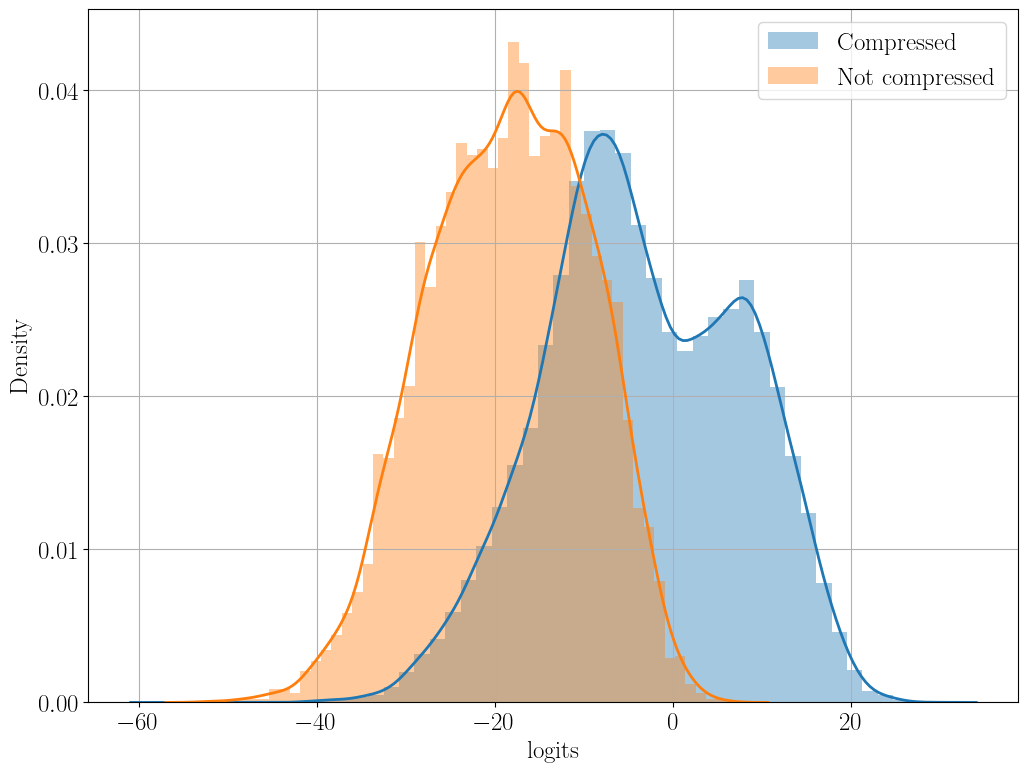

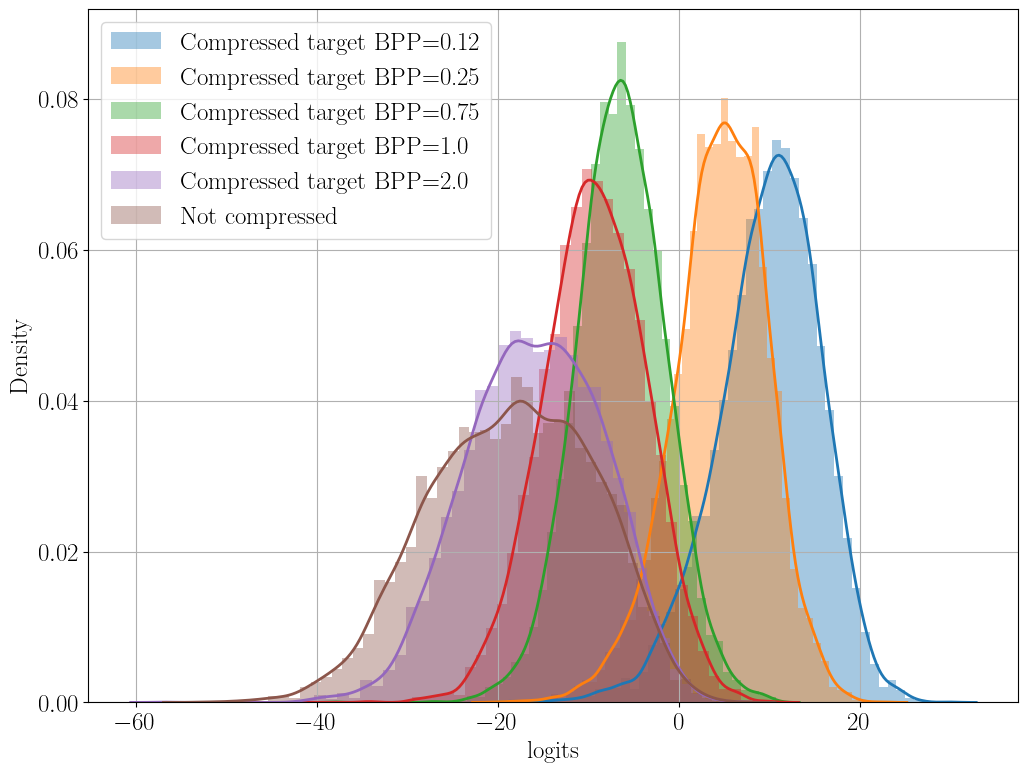

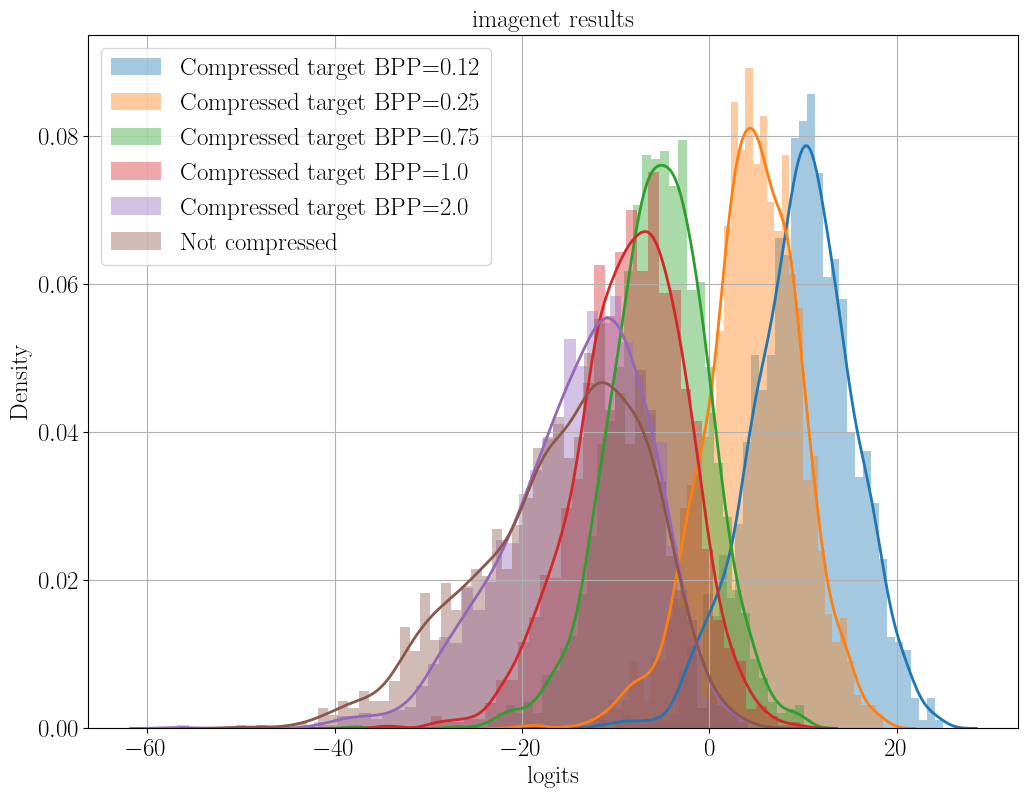

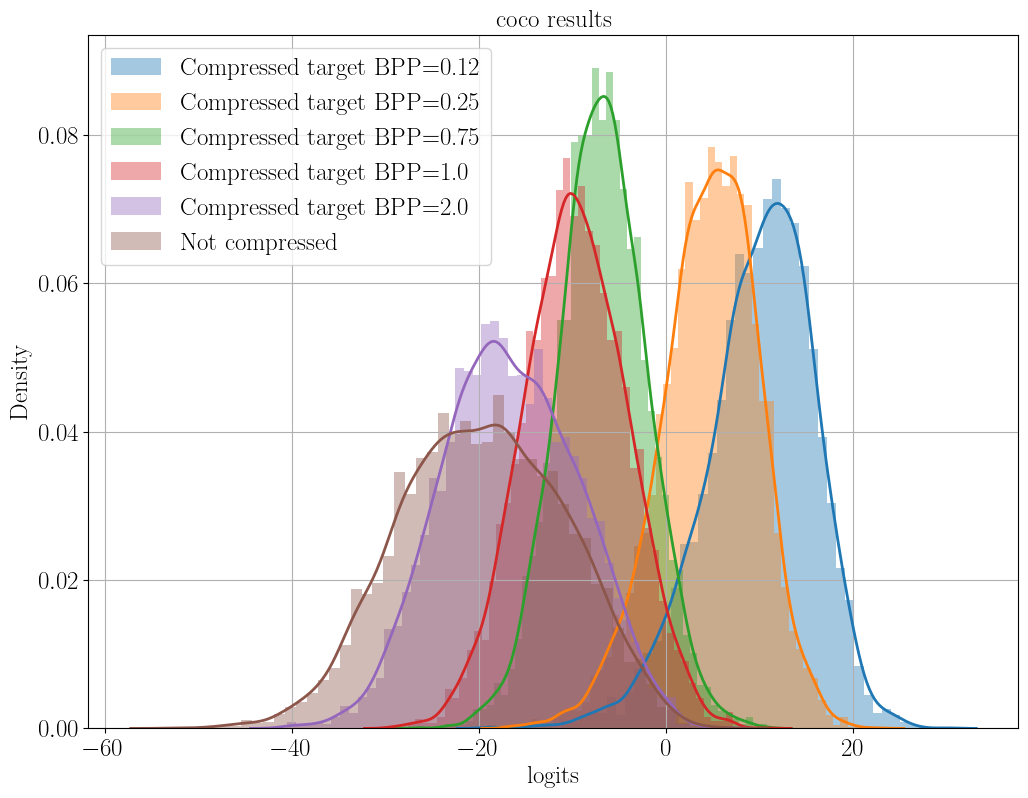

In [14]:
fsize = (12, 9)
# Let's just plot the distribution of the scores divided by compressed or not compressed
plt.figure(figsize=fsize)
compressed = results[results['compressed'] == True]
not_compressed = results[results['compressed'] == False]
counts, compressed_score_bins = np.histogram(compressed['logits'].tolist(), bins=50)
counts, not_compressed_score_bins = np.histogram(not_compressed['logits'].tolist(), bins=50)
seaborn.distplot(compressed['logits'], bins=compressed_score_bins, kde=True, label='Compressed')
seaborn.distplot(not_compressed['logits'], bins=not_compressed_score_bins, kde=True, label='Not compressed')
plt.legend(loc='best')
plt.grid()
plt.show()

# Let's just plot the distribution of the scores divided by target BPP
compressed = results[results['compressed'] == True]
not_compressed = results[results['compressed'] == False]
plt.figure(figsize=fsize)
for target_bpp in compressed['target_bpp'].unique():
    dataset = compressed.loc[compressed['target_bpp']==target_bpp]
    counts, score_bins = np.histogram(dataset['logits'], bins=50)
    seaborn.distplot(dataset['logits'], bins=score_bins, kde=True, label=f'Compressed target BPP={target_bpp}')
counts, not_compressed_score_bins = np.histogram(not_compressed['logits'].tolist(), bins=50)
seaborn.distplot(not_compressed['logits'], bins=not_compressed_score_bins, kde=True, label='Not compressed')
plt.legend(loc='best')
plt.grid()
plt.show()

# Let's just plot the distribution of the scores divided by dataset
for dataset_name in results['dataset'].unique():
    results_dataset = results[results['dataset'] == dataset_name]
    compressed = results_dataset[results_dataset['compressed'] == True]
    not_compressed = results_dataset[results_dataset['compressed'] == False]
    plt.figure(figsize=fsize)
    for target_bpp in compressed['target_bpp'].unique():
        dataset = compressed.loc[compressed['target_bpp']==target_bpp]
        counts, score_bins = np.histogram(dataset['logits'], bins=50)
        seaborn.distplot(dataset['logits'], bins=score_bins, kde=True, label=f'Compressed target BPP={target_bpp}')
    counts, not_compressed_score_bins = np.histogram(not_compressed['logits'].tolist(), bins=50)
    seaborn.distplot(not_compressed['logits'], bins=not_compressed_score_bins, kde=True, label='Not compressed')
    plt.legend(loc='best')
    plt.title(f'{dataset_name} results')
    plt.grid()
    plt.show()


## Let's compute some ROC curves

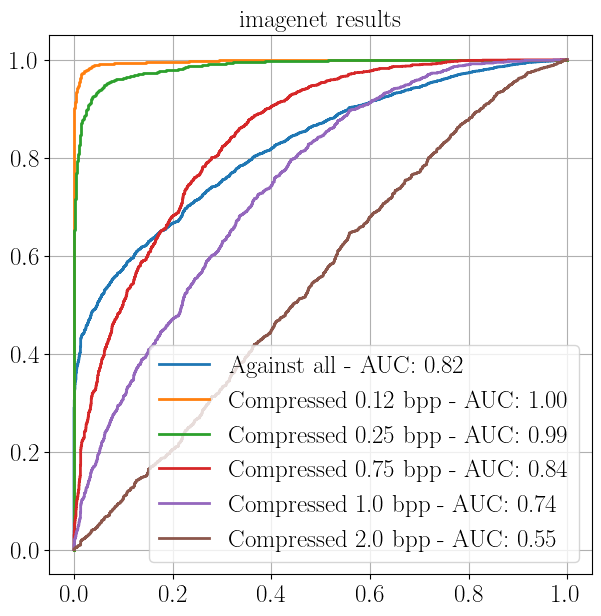

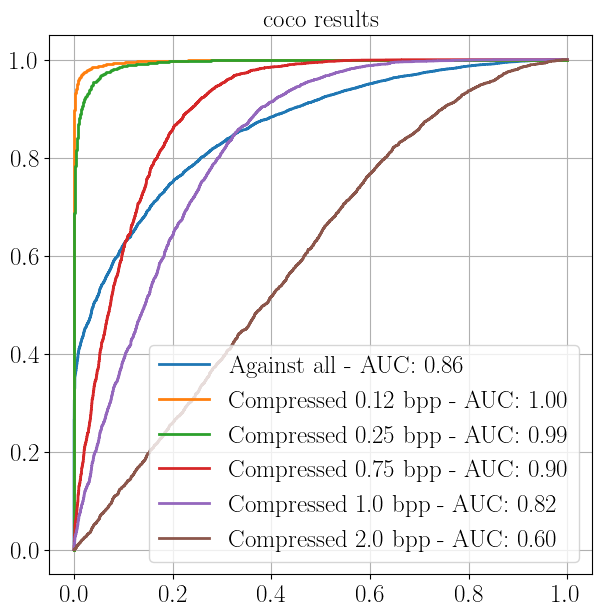

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score


for dataset_name in results['dataset'].unique():
    results_dataset = results[results['dataset'] == dataset_name]
    compressed = results_dataset[results_dataset['compressed'] == True]
    not_compressed = results_dataset[results_dataset['compressed'] == False]
    fpr, tpr, _ = roc_curve(results_dataset['compressed'], results_dataset['logits'])
    # Compute area under the curve
    roc_auc = roc_auc_score(results_dataset['compressed'], results_dataset['logits'])
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, label='Against all - AUC: %.2f' % roc_auc)
    for target_bpp in compressed['target_bpp'].unique():
        dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
        fpr, tpr, _ = roc_curve(dataset['compressed'], dataset['logits'])
        # Compute area under the curve
        roc_auc = roc_auc_score(dataset['compressed'], dataset['logits'])
        plt.plot(fpr, tpr, label=f'Compressed {target_bpp} bpp - AUC: %.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.title(f'{dataset_name} results')
    plt.grid()
    plt.show()


## Let's compute the balanced accuracy at 0.5 threshold

In [16]:
from sklearn.metrics import balanced_accuracy_score
# --- Imagenet results
results_dataset = results[results['dataset'] == 'imagenet']
compressed = results_dataset[results_dataset['compressed'] == True]
not_compressed = results_dataset[results_dataset['compressed'] == False]
balanced_accuracy = balanced_accuracy_score(results_dataset['compressed'], results_dataset['logits'] > 0)
print(f'Balanced accuracy against all: {balanced_accuracy}')
for target_bpp in compressed['target_bpp'].unique():
    dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
    balanced_accuracy = balanced_accuracy_score(dataset['compressed'], dataset['logits'] > 0)
    print(f'Balanced accuracy compressed {target_bpp} bpp: {balanced_accuracy}')

# --- COCO results
results_dataset = results[results['dataset'] == 'coco']
compressed = results_dataset[results_dataset['compressed'] == True]
not_compressed = results_dataset[results_dataset['compressed'] == False]
balanced_accuracy = balanced_accuracy_score(results_dataset['compressed'], results_dataset['logits'] > 0)
print(f'Balanced accuracy against all: {balanced_accuracy}')
for target_bpp in compressed['target_bpp'].unique():
    dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
    balanced_accuracy = balanced_accuracy_score(dataset['compressed'], dataset['logits'] > 0)
    print(f'Balanced accuracy compressed {target_bpp} bpp: {balanced_accuracy}')

Balanced accuracy against all: 0.6933
Balanced accuracy compressed 0.12 bpp: 0.971
Balanced accuracy compressed 0.25 bpp: 0.90725
Balanced accuracy compressed 0.75 bpp: 0.56525
Balanced accuracy compressed 1.0 bpp: 0.524
Balanced accuracy compressed 2.0 bpp: 0.499
Balanced accuracy against all: 0.68568
Balanced accuracy compressed 0.12 bpp: 0.9686999999999999
Balanced accuracy compressed 0.25 bpp: 0.907
Balanced accuracy compressed 0.75 bpp: 0.5355
Balanced accuracy compressed 1.0 bpp: 0.5169
Balanced accuracy compressed 2.0 bpp: 0.5003


## Grag2021 latent

In [17]:
results = pd.read_csv(os.path.join(results_dir, 'Grag2021_latent', 'results.csv'))
results

,Unnamed: 0,path,dataset,compressed,target_bpp,filename,content,size,logits
0,81384,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,456--n02879718_10059.png,various,"(256, 256)",-8.106772
1,81385,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,122--n01983481_8922.png,various,"(256, 256)",-21.922688
2,81386,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,730--n03967562_27019.png,various,"(256, 256)",-19.569073
3,81387,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,635--n03706229_5361.png,various,"(256, 256)",-21.799458
4,81388,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,753--n04040759_4271.png,various,"(256, 256)",-10.132582
...,...,...,...,...,...,...,...,...,...
41995,123379,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000055950.png,various,"(256, 256)",-17.316441
41996,123380,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000488736.png,various,"(256, 256)",-30.628532
41997,123381,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000473869.png,various,"(256, 256)",-28.054861
41998,123382,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000248980.png,various,"(256, 256)",-26.095781


### Scores distribution

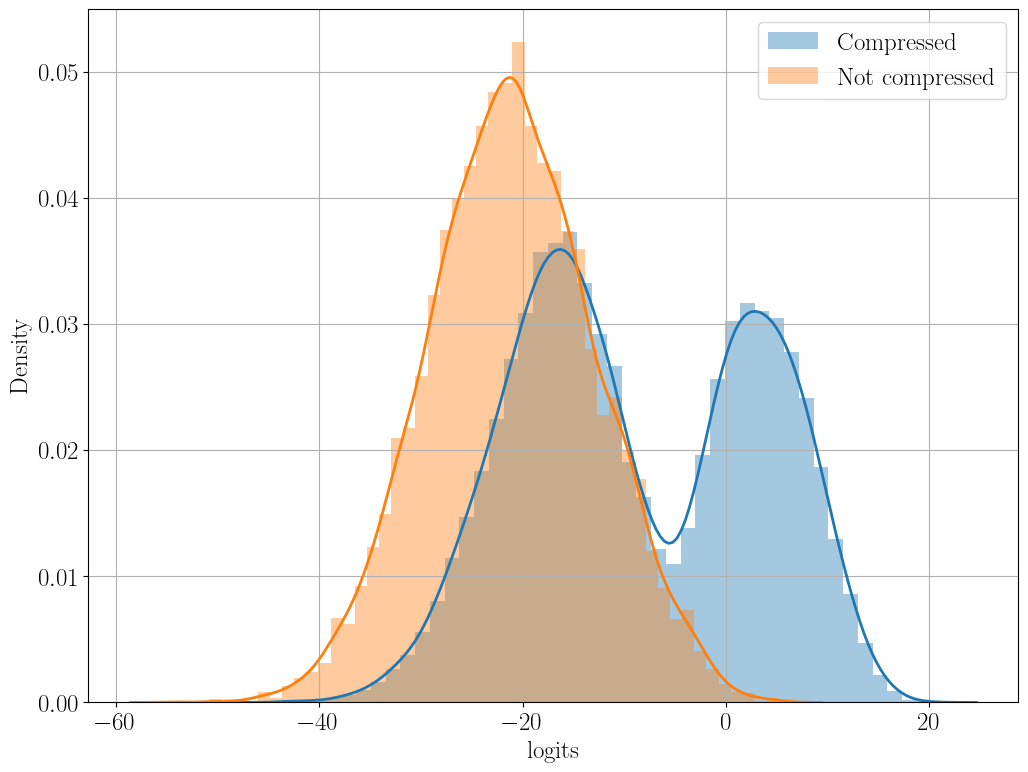

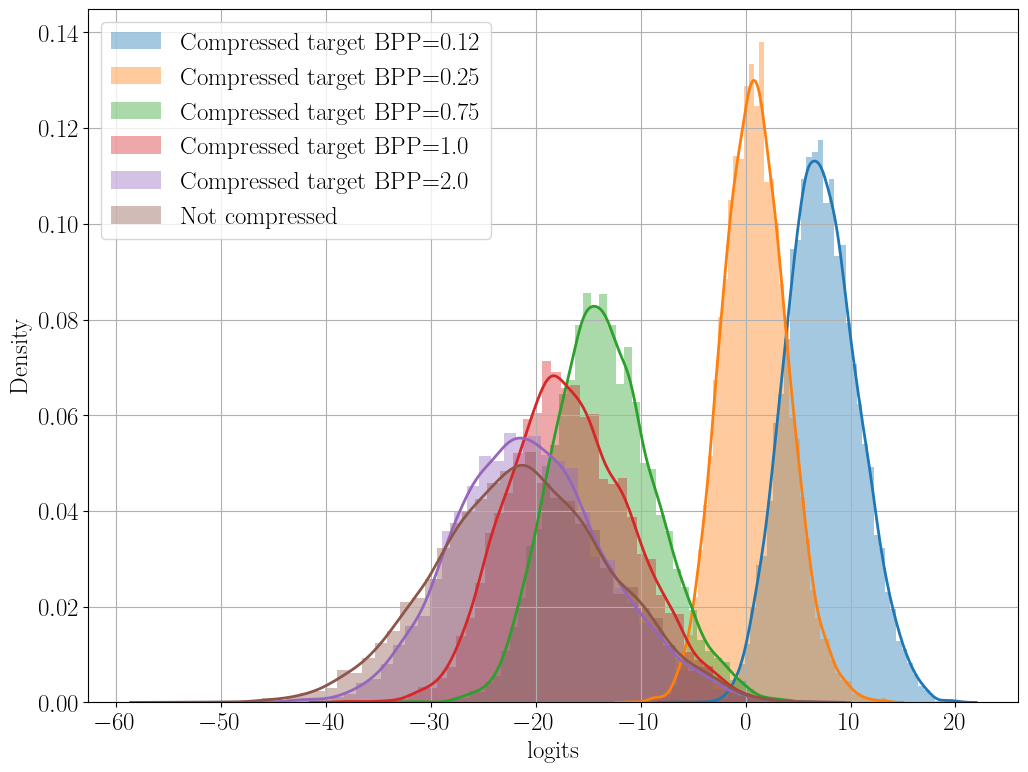

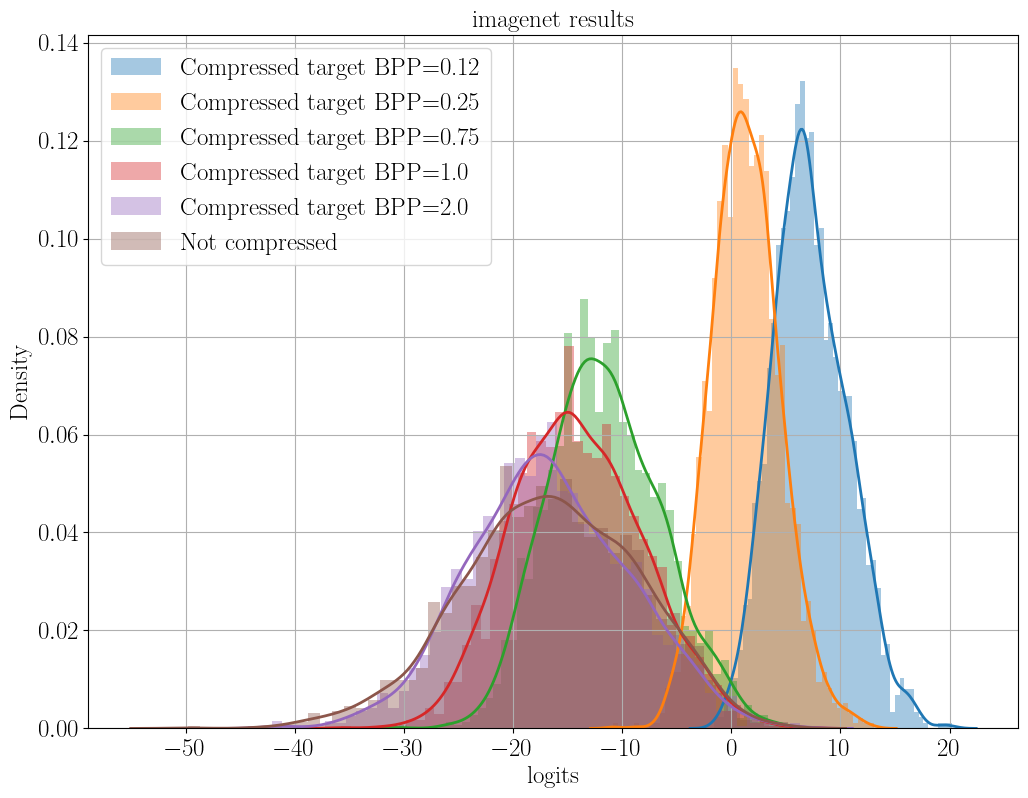

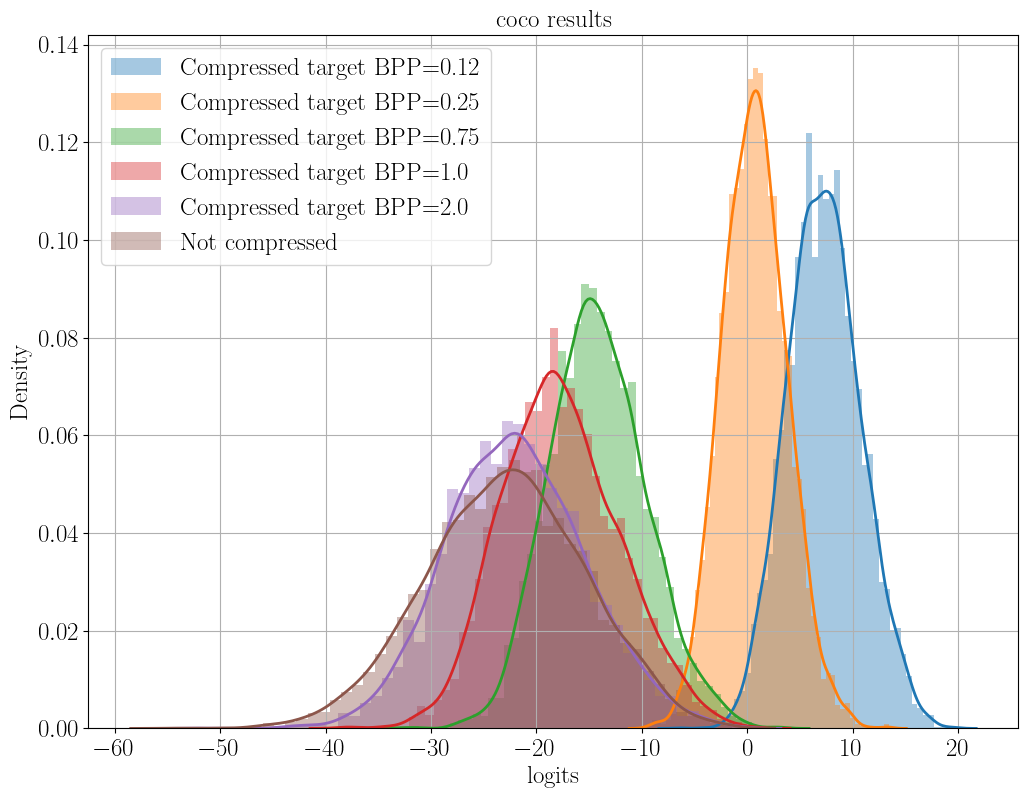

In [18]:
fsize = (12, 9)
# Let's just plot the distribution of the scores divided by compressed or not compressed
plt.figure(figsize=fsize)
compressed = results[results['compressed'] == True]
not_compressed = results[results['compressed'] == False]
counts, compressed_score_bins = np.histogram(compressed['logits'].tolist(), bins=50)
counts, not_compressed_score_bins = np.histogram(not_compressed['logits'].tolist(), bins=50)
seaborn.distplot(compressed['logits'], bins=compressed_score_bins, kde=True, label='Compressed')
seaborn.distplot(not_compressed['logits'], bins=not_compressed_score_bins, kde=True, label='Not compressed')
plt.legend(loc='best')
plt.grid()
plt.show()

# Let's just plot the distribution of the scores divided by target BPP
compressed = results[results['compressed'] == True]
not_compressed = results[results['compressed'] == False]
plt.figure(figsize=fsize)
for target_bpp in compressed['target_bpp'].unique():
    dataset = compressed.loc[compressed['target_bpp']==target_bpp]
    counts, score_bins = np.histogram(dataset['logits'], bins=50)
    seaborn.distplot(dataset['logits'], bins=score_bins, kde=True, label=f'Compressed target BPP={target_bpp}')
counts, not_compressed_score_bins = np.histogram(not_compressed['logits'].tolist(), bins=50)
seaborn.distplot(not_compressed['logits'], bins=not_compressed_score_bins, kde=True, label='Not compressed')
plt.legend(loc='best')
plt.grid()
plt.show()

# Let's just plot the distribution of the scores divided by dataset
for dataset_name in results['dataset'].unique():
    results_dataset = results[results['dataset'] == dataset_name]
    compressed = results_dataset[results_dataset['compressed'] == True]
    not_compressed = results_dataset[results_dataset['compressed'] == False]
    plt.figure(figsize=fsize)
    for target_bpp in compressed['target_bpp'].unique():
        dataset = compressed.loc[compressed['target_bpp']==target_bpp]
        counts, score_bins = np.histogram(dataset['logits'], bins=50)
        seaborn.distplot(dataset['logits'], bins=score_bins, kde=True, label=f'Compressed target BPP={target_bpp}')
    counts, not_compressed_score_bins = np.histogram(not_compressed['logits'].tolist(), bins=50)
    seaborn.distplot(not_compressed['logits'], bins=not_compressed_score_bins, kde=True, label='Not compressed')
    plt.legend(loc='best')
    plt.title(f'{dataset_name} results')
    plt.grid()
    plt.show()


### ROC curves

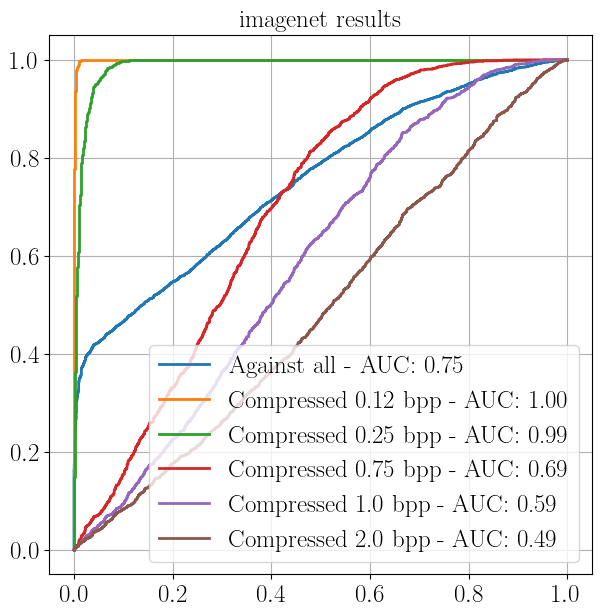

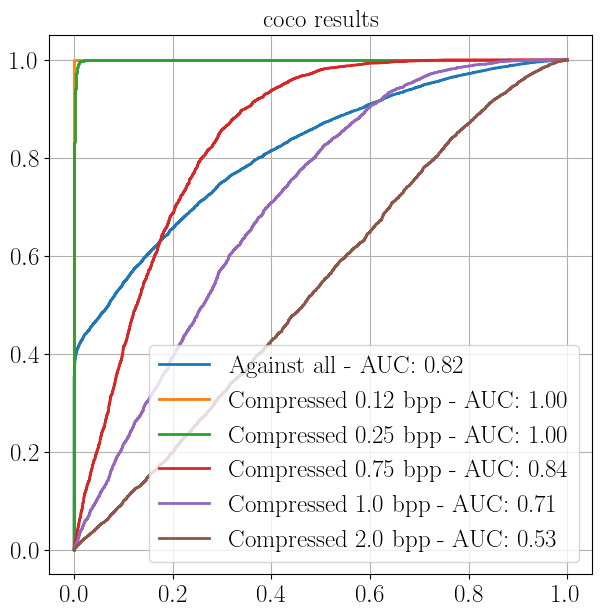

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score


for dataset_name in results['dataset'].unique():
    results_dataset = results[results['dataset'] == dataset_name]
    compressed = results_dataset[results_dataset['compressed'] == True]
    not_compressed = results_dataset[results_dataset['compressed'] == False]
    fpr, tpr, _ = roc_curve(results_dataset['compressed'], results_dataset['logits'])
    # Compute area under the curve
    roc_auc = roc_auc_score(results_dataset['compressed'], results_dataset['logits'])
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, label='Against all - AUC: %.2f' % roc_auc)
    for target_bpp in compressed['target_bpp'].unique():
        dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
        fpr, tpr, _ = roc_curve(dataset['compressed'], dataset['logits'])
        # Compute area under the curve
        roc_auc = roc_auc_score(dataset['compressed'], dataset['logits'])
        plt.plot(fpr, tpr, label=f'Compressed {target_bpp} bpp - AUC: %.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.title(f'{dataset_name} results')
    plt.grid()
    plt.show()


### Balanced accuracy score

In [20]:
from sklearn.metrics import balanced_accuracy_score

for dataset_name in results['dataset'].unique():
    results_dataset = results[results['dataset'] == dataset_name]
    compressed = results_dataset[results_dataset['compressed'] == True]
    not_compressed = results_dataset[results_dataset['compressed'] == False]
    balanced_accuracy = balanced_accuracy_score(results_dataset['compressed'], results_dataset['logits'] > 0)
    print(f'{dataset_name} balanced accuracy against all: {balanced_accuracy}')
    for target_bpp in compressed['target_bpp'].unique():
        dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
        balanced_accuracy = balanced_accuracy_score(dataset['compressed'], dataset['logits'] > 0)
        print(f'{dataset_name} balanced accuracy compressed {target_bpp} bpp: {balanced_accuracy}')

imagenet balanced accuracy against all: 0.664
imagenet balanced accuracy compressed 0.12 bpp: 0.9910000000000001
imagenet balanced accuracy compressed 0.25 bpp: 0.8265
imagenet balanced accuracy compressed 0.75 bpp: 0.5025000000000001
imagenet balanced accuracy compressed 1.0 bpp: 0.5005000000000001
imagenet balanced accuracy compressed 2.0 bpp: 0.4995
coco balanced accuracy against all: 0.65782
coco balanced accuracy compressed 0.12 bpp: 0.9943
coco balanced accuracy compressed 0.25 bpp: 0.7938000000000001
coco balanced accuracy compressed 0.75 bpp: 0.5008
coco balanced accuracy compressed 1.0 bpp: 0.5002
coco balanced accuracy compressed 2.0 bpp: 0.5


## Wang2023

In [21]:
results = pd.read_csv(os.path.join(results_dir, 'Wang2023', 'results.csv'))
results

,Unnamed: 0,path,dataset,compressed,target_bpp,filename,content,size,mode,logits
0,0,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,13700.png,cat,"(256, 256)",RGB,-11.609918
1,1,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,10175.png,cat,"(256, 256)",RGB,-8.329074
2,2,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,17311.png,cat,"(256, 256)",RGB,-5.107549
3,3,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,09090.png,cat,"(256, 256)",RGB,-10.914184
4,4,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,17172.png,cat,"(256, 256)",RGB,-10.896344
...,...,...,...,...,...,...,...,...,...,...
142453,142453,/nas/public/exchange/JPEG-AI/data/TEST/laion/c...,laion,True,2.0,vmrobijbmc.png,various,"(256, 256)",RGB,-1.835806
142454,142454,/nas/public/exchange/JPEG-AI/data/TEST/laion/c...,laion,True,2.0,medbpbsmum.png,various,"(256, 256)",RGB,-5.351993
142455,142455,/nas/public/exchange/JPEG-AI/data/TEST/laion/c...,laion,True,2.0,nrzbgujfll.png,various,"(256, 256)",RGB,-3.195621
142456,142456,/nas/public/exchange/JPEG-AI/data/TEST/laion/c...,laion,True,2.0,sqtxlhaqbh.png,various,"(256, 256)",RGB,-11.852911


## Let's plot the scores

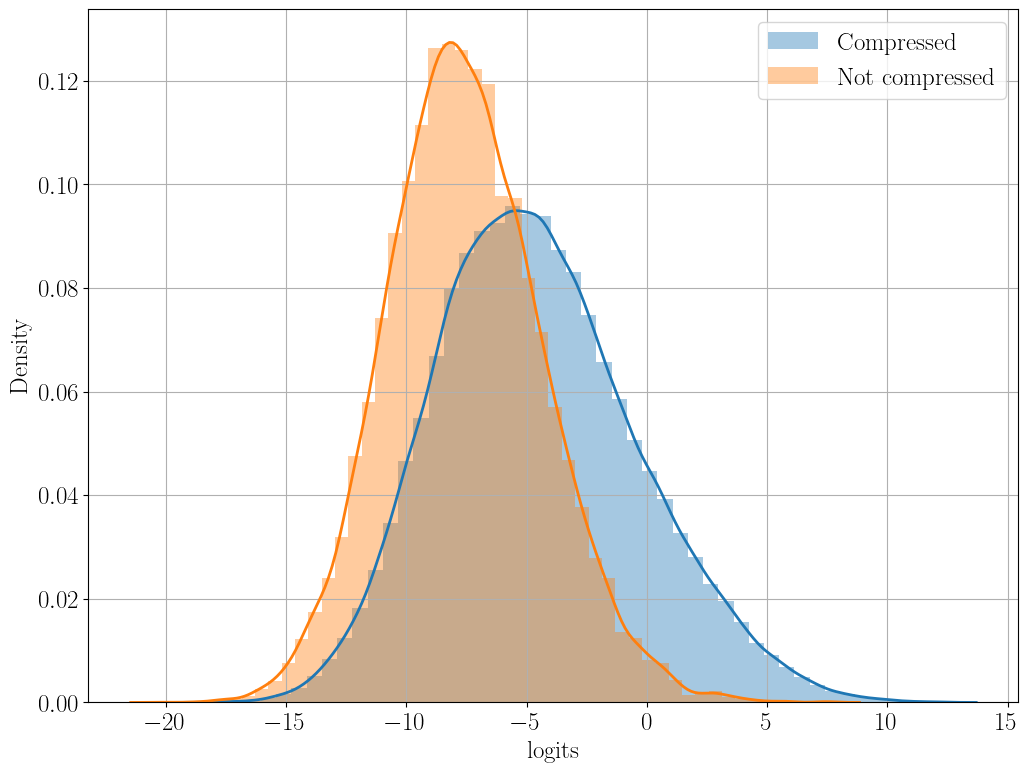

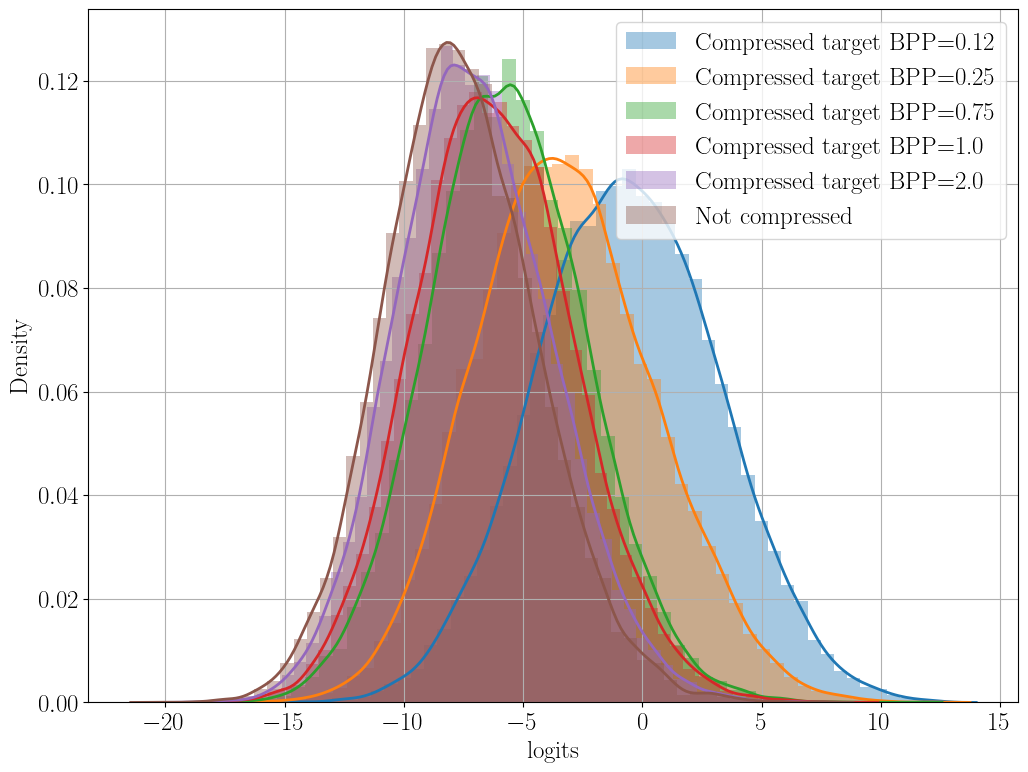

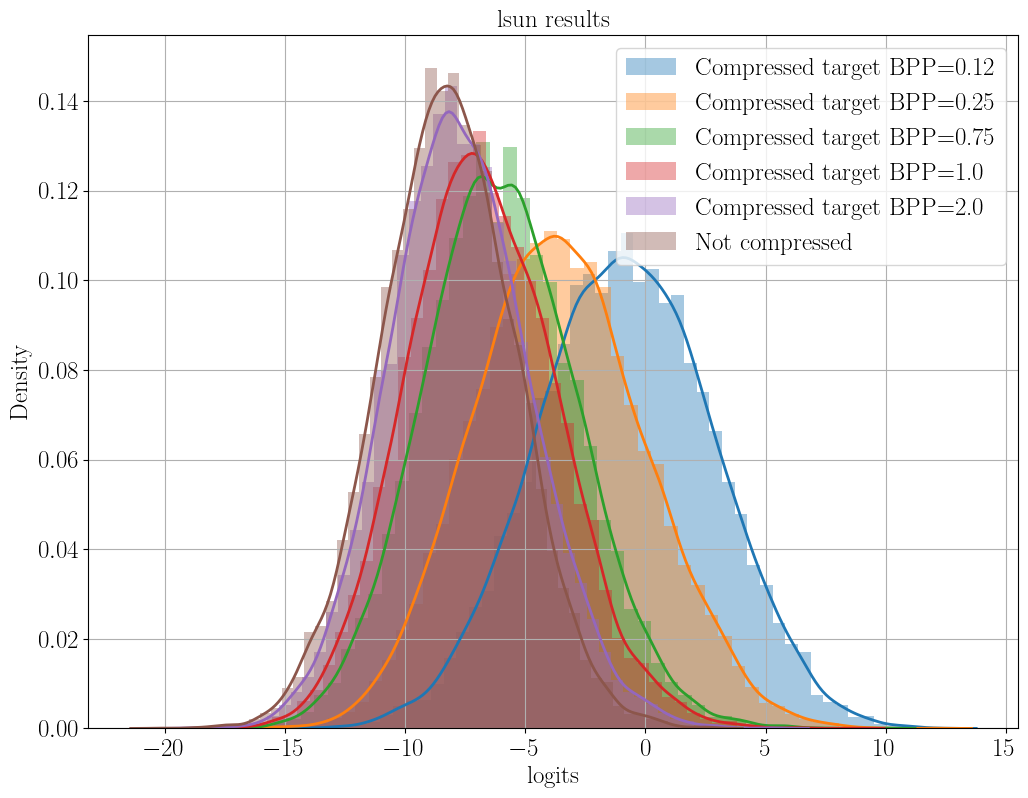

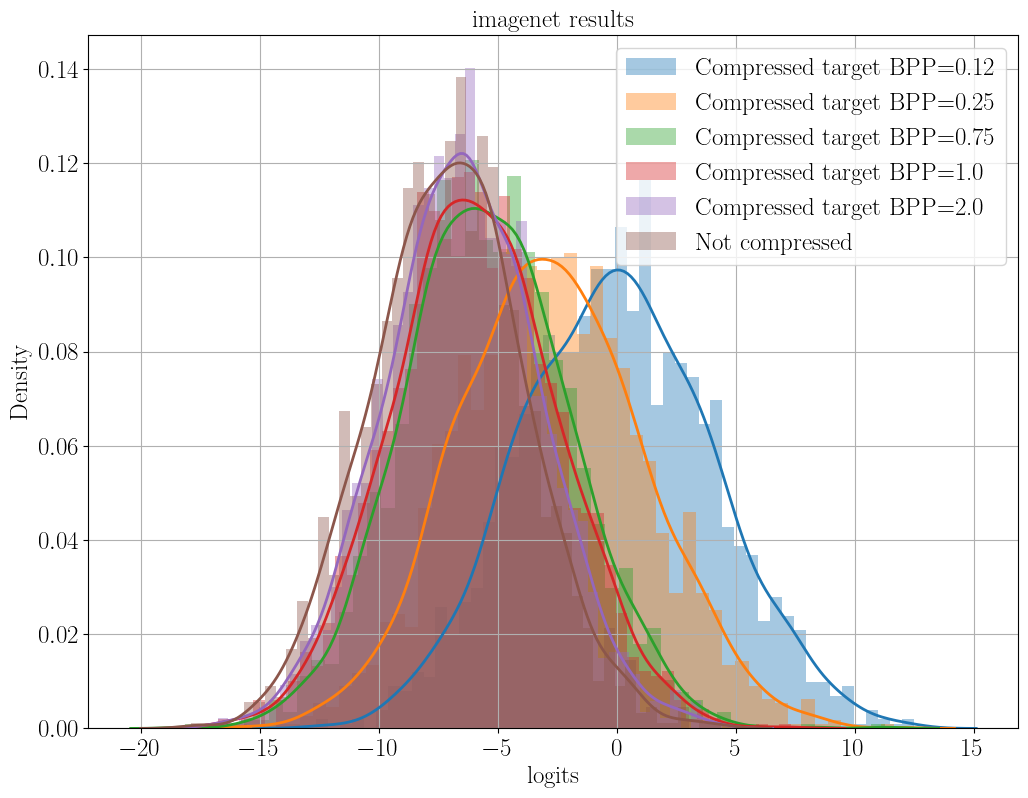

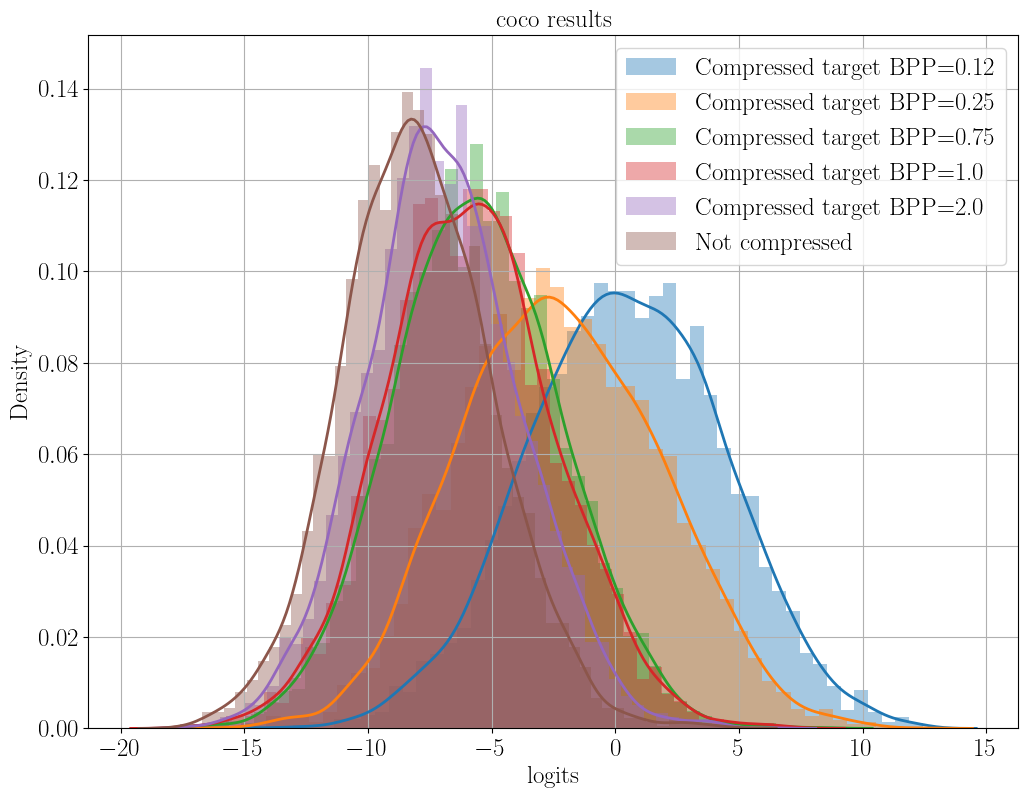

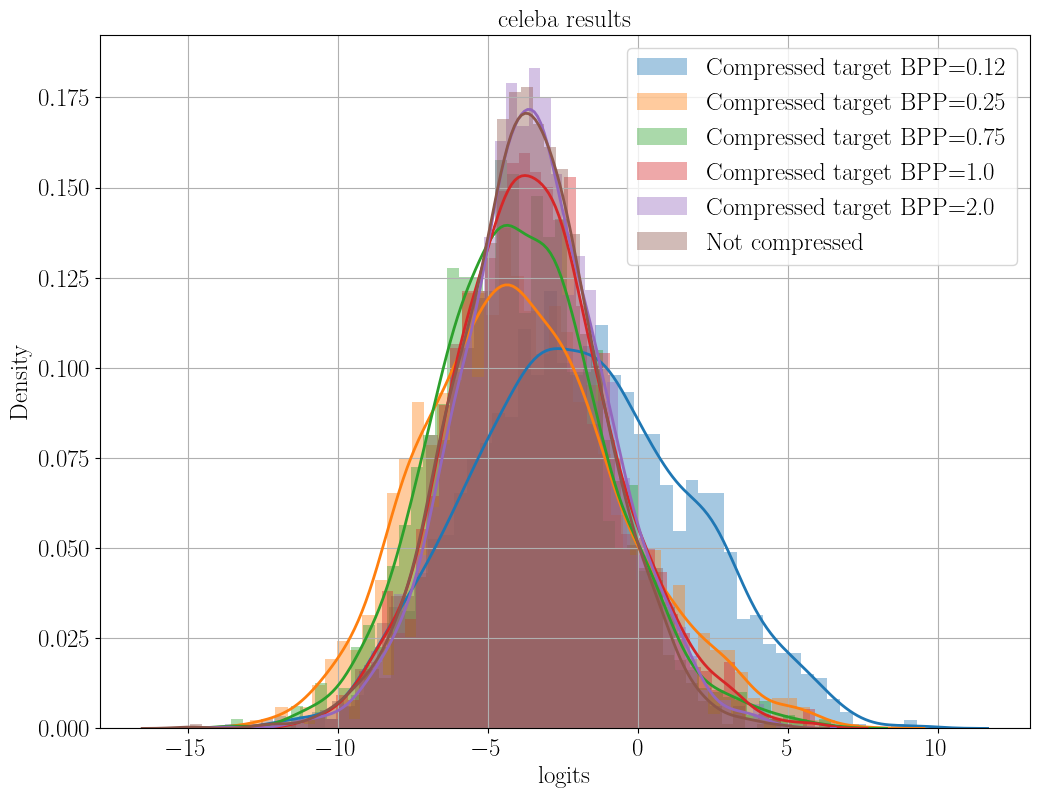

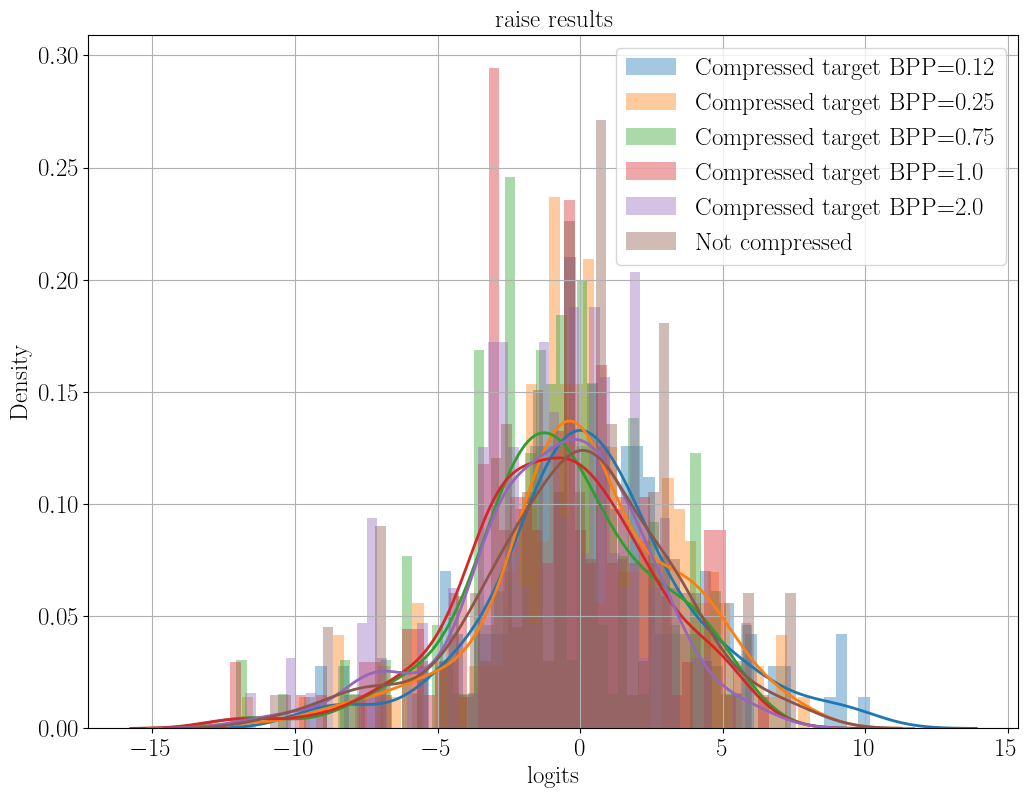

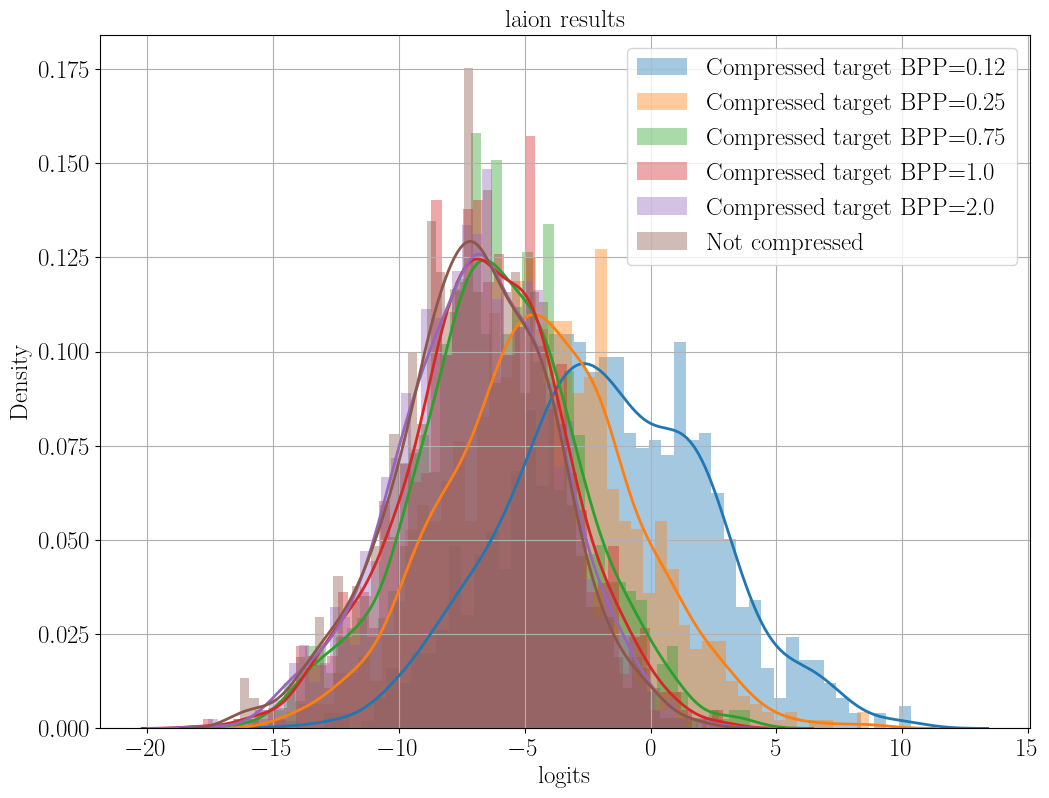

In [22]:
fsize = (12, 9)
# Let's just plot the distribution of the scores divided by compressed or not compressed
plt.figure(figsize=fsize)
compressed = results[results['compressed'] == True]
not_compressed = results[results['compressed'] == False]
counts, compressed_score_bins = np.histogram(compressed['logits'].tolist(), bins=50)
counts, not_compressed_score_bins = np.histogram(not_compressed['logits'].tolist(), bins=50)
seaborn.distplot(compressed['logits'], bins=compressed_score_bins, kde=True, label='Compressed')
seaborn.distplot(not_compressed['logits'], bins=not_compressed_score_bins, kde=True, label='Not compressed')
plt.legend(loc='best')
plt.grid()
plt.show()

# Let's just plot the distribution of the scores divided by target BPP
compressed = results[results['compressed'] == True]
not_compressed = results[results['compressed'] == False]
plt.figure(figsize=fsize)
for target_bpp in compressed['target_bpp'].unique():
    dataset = compressed.loc[compressed['target_bpp']==target_bpp]
    counts, score_bins = np.histogram(dataset['logits'], bins=50)
    seaborn.distplot(dataset['logits'], bins=score_bins, kde=True, label=f'Compressed target BPP={target_bpp}')
counts, not_compressed_score_bins = np.histogram(not_compressed['logits'].tolist(), bins=50)
seaborn.distplot(not_compressed['logits'], bins=not_compressed_score_bins, kde=True, label='Not compressed')
plt.legend(loc='best')
plt.grid()
plt.show()

# Let's just plot the distribution of the scores divided by dataset
for dataset_name in results['dataset'].unique():
    results_dataset = results[results['dataset'] == dataset_name]
    compressed = results_dataset[results_dataset['compressed'] == True]
    not_compressed = results_dataset[results_dataset['compressed'] == False]
    plt.figure(figsize=fsize)
    for target_bpp in compressed['target_bpp'].unique():
        dataset = compressed.loc[compressed['target_bpp']==target_bpp]
        counts, score_bins = np.histogram(dataset['logits'], bins=50)
        seaborn.distplot(dataset['logits'], bins=score_bins, kde=True, label=f'Compressed target BPP={target_bpp}')
    counts, not_compressed_score_bins = np.histogram(not_compressed['logits'].tolist(), bins=50)
    seaborn.distplot(not_compressed['logits'], bins=not_compressed_score_bins, kde=True, label='Not compressed')
    plt.legend(loc='best')
    plt.title(f'{dataset_name} results')
    plt.grid()
    plt.show()


### Let's compute some ROC curves

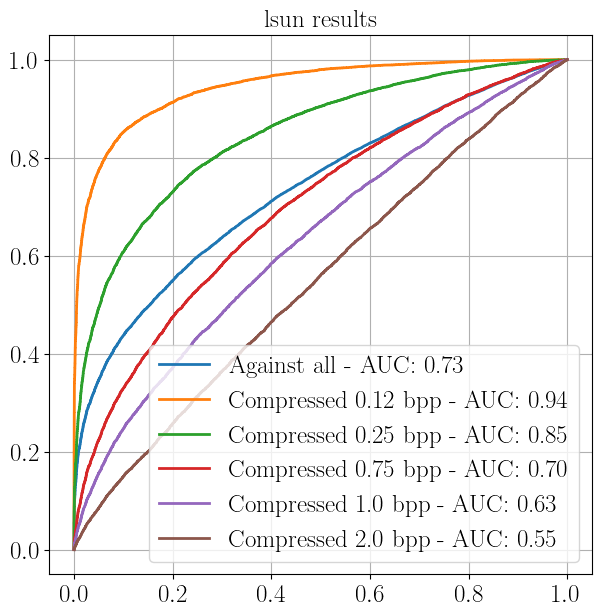

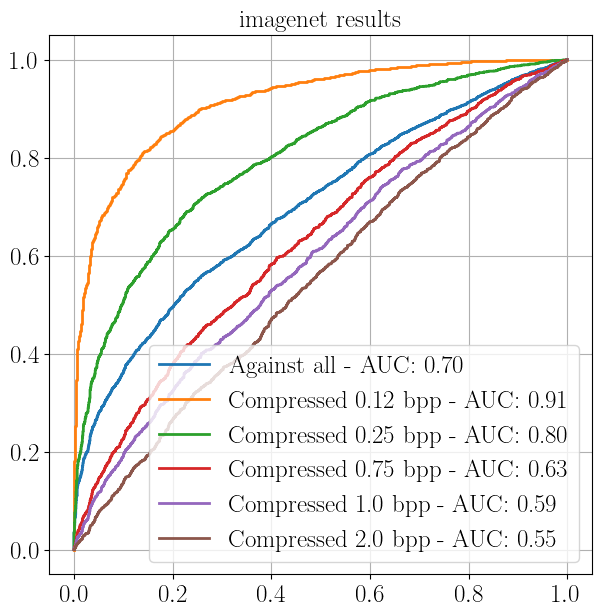

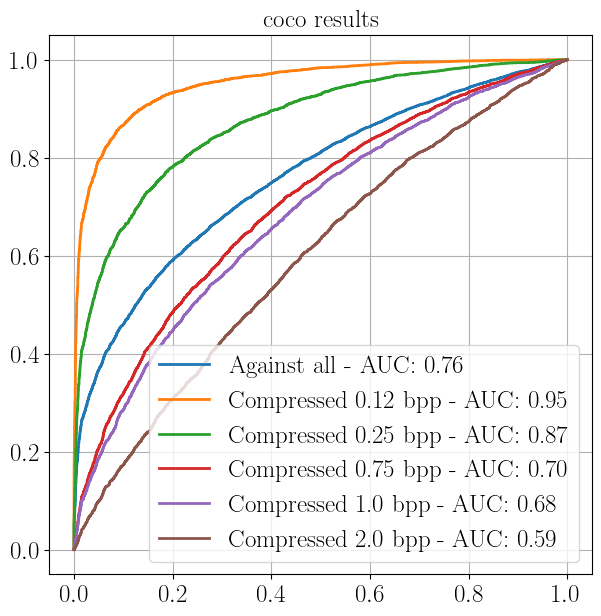

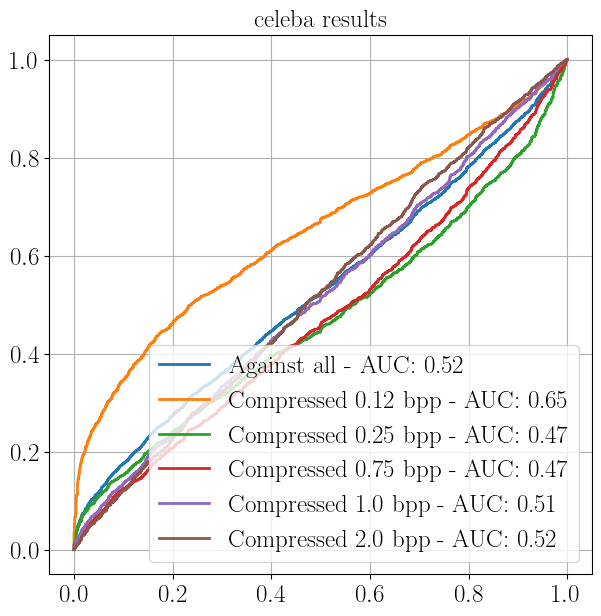

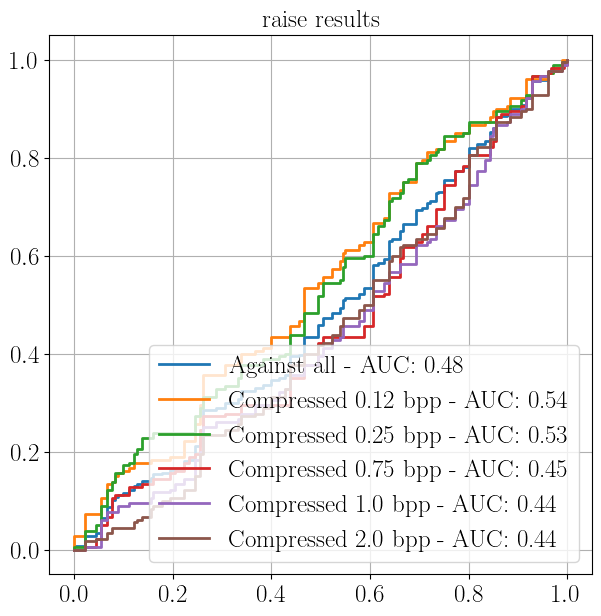

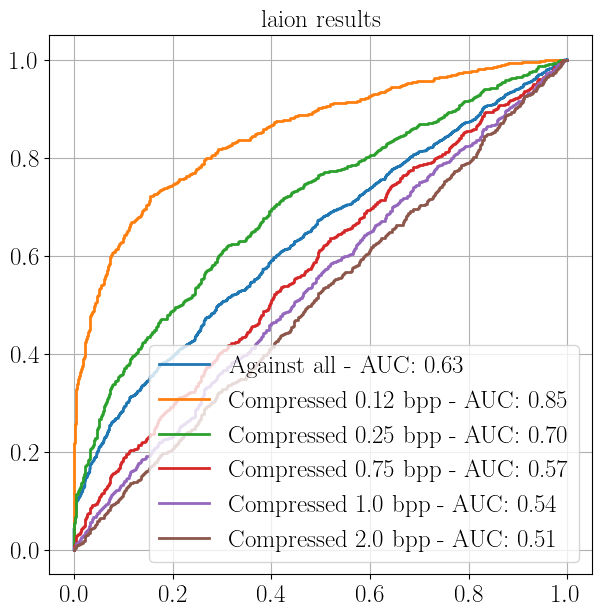

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score


for dataset_name in results['dataset'].unique():
    results_dataset = results[results['dataset'] == dataset_name]
    compressed = results_dataset[results_dataset['compressed'] == True]
    not_compressed = results_dataset[results_dataset['compressed'] == False]
    fpr, tpr, _ = roc_curve(results_dataset['compressed'], results_dataset['logits'])
    # Compute area under the curve
    roc_auc = roc_auc_score(results_dataset['compressed'], results_dataset['logits'])
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, label='Against all - AUC: %.2f' % roc_auc)
    for target_bpp in compressed['target_bpp'].unique():
        dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
        fpr, tpr, _ = roc_curve(dataset['compressed'], dataset['logits'])
        # Compute area under the curve
        roc_auc = roc_auc_score(dataset['compressed'], dataset['logits'])
        plt.plot(fpr, tpr, label=f'Compressed {target_bpp} bpp - AUC: %.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.title(f'{dataset_name} results')
    plt.grid()
    plt.show()


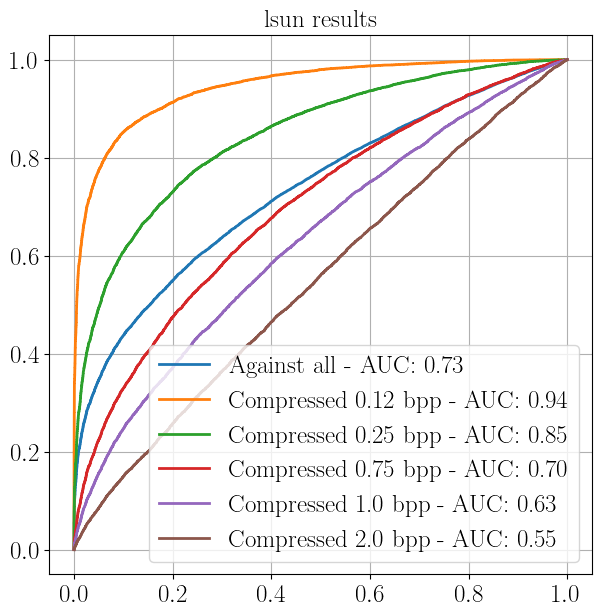

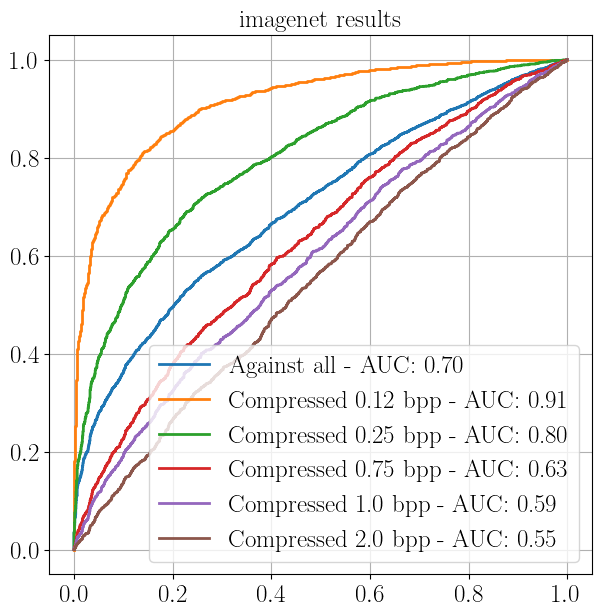

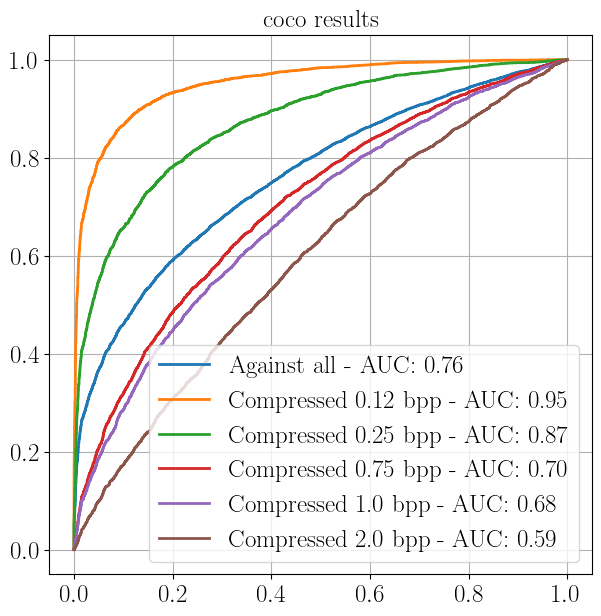

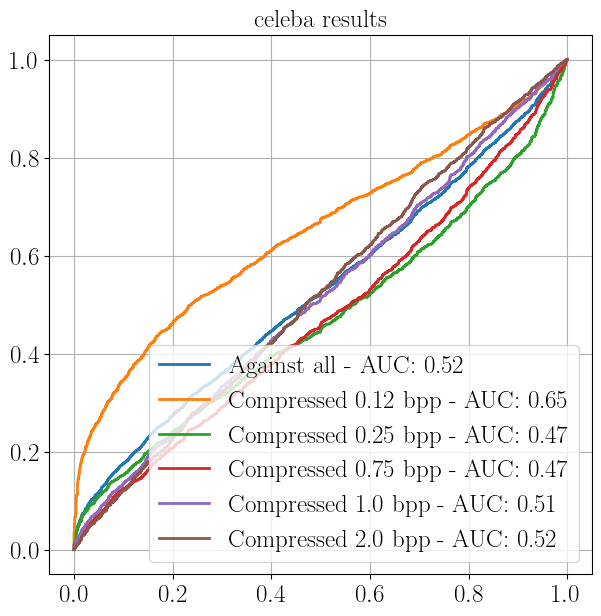

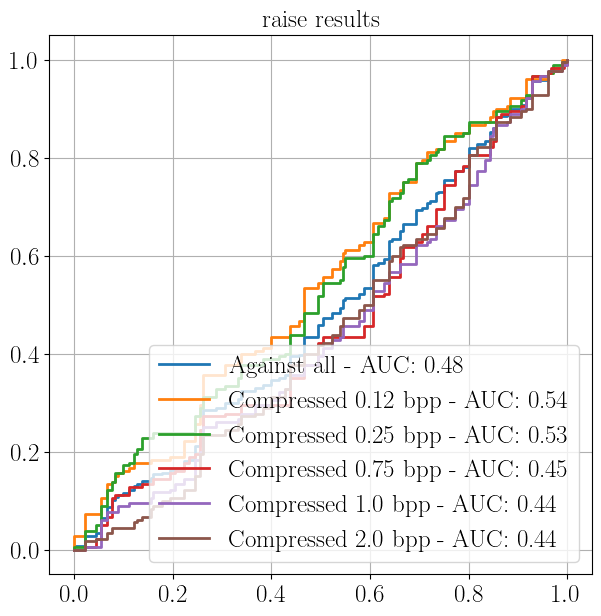

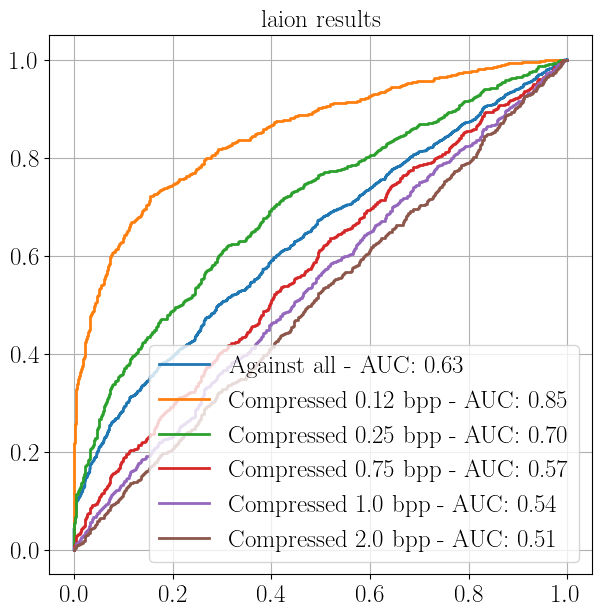

In [24]:
### With sigmoid
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.special import expit


for dataset_name in results['dataset'].unique():
    results_dataset = results[results['dataset'] == dataset_name]
    compressed = results_dataset[results_dataset['compressed'] == True]
    not_compressed = results_dataset[results_dataset['compressed'] == False]
    fpr, tpr, _ = roc_curve(results_dataset['compressed'], results_dataset['logits'].apply(lambda x: expit(x)))
    # Compute area under the curve
    roc_auc = roc_auc_score(results_dataset['compressed'], results_dataset['logits'].apply(lambda x: expit(x)))
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, label='Against all - AUC: %.2f' % roc_auc)
    for target_bpp in compressed['target_bpp'].unique():
        dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
        fpr, tpr, _ = roc_curve(dataset['compressed'], dataset['logits'])
        # Compute area under the curve
        roc_auc = roc_auc_score(dataset['compressed'], dataset['logits'])
        plt.plot(fpr, tpr, label=f'Compressed {target_bpp} bpp - AUC: %.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.title(f'{dataset_name} results')
    plt.grid()
    plt.show()


### Let's see some balanced accuracy scores

In [25]:
from sklearn.metrics import balanced_accuracy_score
from scipy.special import expit

for dataset_name in results['dataset'].unique():
    results_dataset = results[results['dataset'] == dataset_name]
    compressed = results_dataset[results_dataset['compressed'] == True]
    not_compressed = results_dataset[results_dataset['compressed'] == False]
    balanced_accuracy = balanced_accuracy_score(results_dataset['compressed'], results_dataset['logits'].apply(lambda x: expit(x)) > 0.5)
    print(f'{dataset_name} Balanced accuracy against all: {balanced_accuracy}')
    for target_bpp in compressed['target_bpp'].unique():
        dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
        balanced_accuracy = balanced_accuracy_score(dataset['compressed'], dataset['logits'].apply(lambda x: expit(x)) > 0.5)
        print(f'{dataset_name} balanced accuracy compressed {target_bpp} bpp: {balanced_accuracy}')


lsun Balanced accuracy against all: 0.5619065172515482
lsun balanced accuracy compressed 0.12 bpp: 0.7043644942494839
lsun balanced accuracy compressed 0.25 bpp: 0.5789221468593335
lsun balanced accuracy compressed 0.75 bpp: 0.5151872603951637
lsun balanced accuracy compressed 1.0 bpp: 0.5085889118254202
lsun balanced accuracy compressed 2.0 bpp: 0.5024697729283397
imagenet Balanced accuracy against all: 0.57735
imagenet balanced accuracy compressed 0.12 bpp: 0.73825
imagenet balanced accuracy compressed 0.25 bpp: 0.6085
imagenet balanced accuracy compressed 0.75 bpp: 0.52275
imagenet balanced accuracy compressed 1.0 bpp: 0.5135
imagenet balanced accuracy compressed 2.0 bpp: 0.50375
coco Balanced accuracy against all: 0.5908
coco balanced accuracy compressed 0.12 bpp: 0.7654
coco balanced accuracy compressed 0.25 bpp: 0.6437999999999999
coco balanced accuracy compressed 0.75 bpp: 0.5219
coco balanced accuracy compressed 1.0 bpp: 0.5194
coco balanced accuracy compressed 2.0 bpp: 0.5035
